In [1]:
# ricorda di rimuovere alla fine perché occupa 800MB
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

In [2]:
# meglio metterlo per riproducibilità
torch.manual_seed(111);

In [3]:
# esempio con dati che riproducono la forma della funzione seno
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
train_data[:, 1] = torch.sin(train_data[:, 0])
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

In [4]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [5]:
# estraggo dei dati a caso per essere il train set
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

## Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256), # primo hidden layer con 256 neuroni con ReLu
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1), # neurone di output ocn attivazione a sigmoide
            nn.Sigmoid(),
        )

    # com'è calcolato l'output del modello
    def forward(self, x):
        output = self.model(x)
        return output

In [7]:
discriminator = Discriminator()

## Generator

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

## Training

In [9]:
lr = 0.001 # tasso di apprendimento
num_epochs = 300 # quante ripetizioni sul training set
loss_function = nn.BCELoss() # funzione di loss (binary cross-entropy)

In [10]:
# ottimizzatore con algoritmo di Adam
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [11]:
# implementazione del training
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # dati da dare al discriminatore
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # allenamento del discriminatore
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # dati da dare al generatore
        latent_space_samples = torch.randn((batch_size, 2))

        # allenamento del generatore
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # visualizza funzione di loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.19172893464565277
Epoch: 0 Loss G.: 2.205277681350708
Epoch: 10 Loss D.: 0.6455698013305664
Epoch: 10 Loss G.: 0.8941397070884705
Epoch: 20 Loss D.: 0.6453320384025574
Epoch: 20 Loss G.: 0.8890978693962097
Epoch: 30 Loss D.: 0.6027293801307678
Epoch: 30 Loss G.: 1.0925241708755493
Epoch: 40 Loss D.: 0.5988795161247253
Epoch: 40 Loss G.: 0.893737256526947
Epoch: 50 Loss D.: 0.6538512706756592
Epoch: 50 Loss G.: 0.7250615358352661
Epoch: 60 Loss D.: 0.6476534605026245
Epoch: 60 Loss G.: 0.7206212878227234
Epoch: 70 Loss D.: 0.6404522657394409
Epoch: 70 Loss G.: 0.9210346937179565
Epoch: 80 Loss D.: 0.6050862669944763
Epoch: 80 Loss G.: 0.8678811192512512
Epoch: 90 Loss D.: 0.6960200071334839
Epoch: 90 Loss G.: 0.9877095818519592
Epoch: 100 Loss D.: 0.6760662198066711
Epoch: 100 Loss G.: 0.8375099897384644
Epoch: 110 Loss D.: 0.6256373524665833
Epoch: 110 Loss G.: 0.8139169812202454
Epoch: 120 Loss D.: 0.6630818843841553
Epoch: 120 Loss G.: 0.8554103374481201
Epoch: 13

In [12]:
# prendo qualche valore random da cui il generatore deve partire
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)

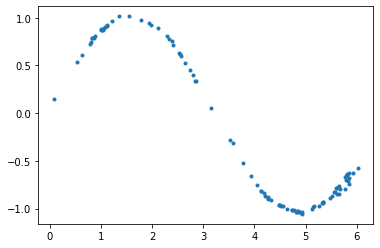

In [13]:
# possiamo vedere che i dati generati sono molto simili alla distribuzione che si vuole ottenere
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")